In [16]:
import numpy as np
from PIL import Image
import cv2
from scipy import ndimage
from skimage import feature, filters

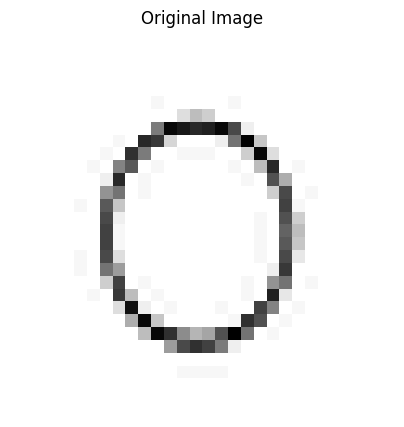

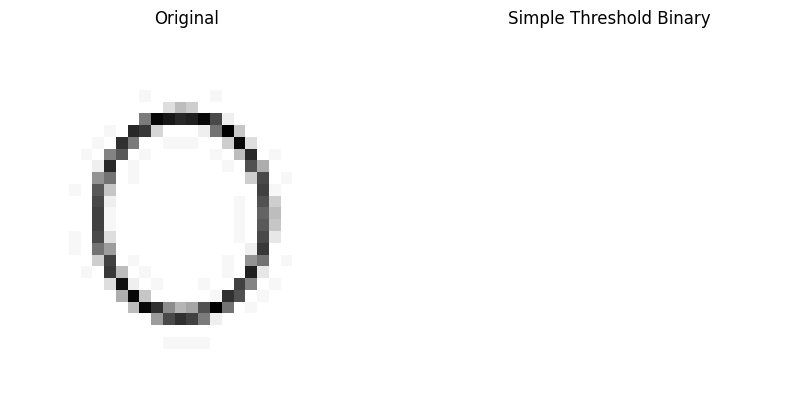

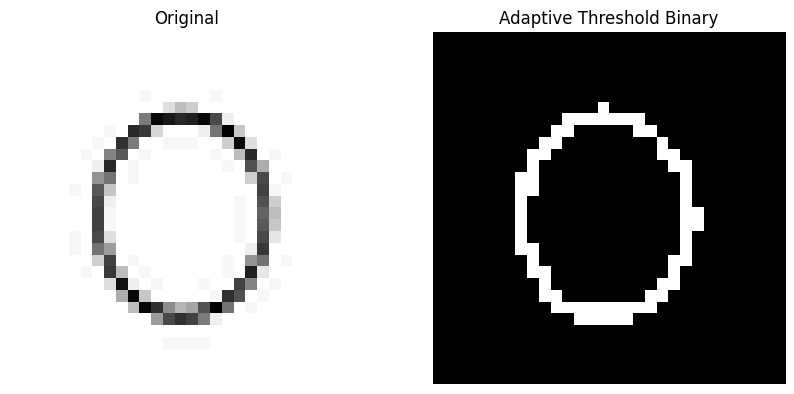

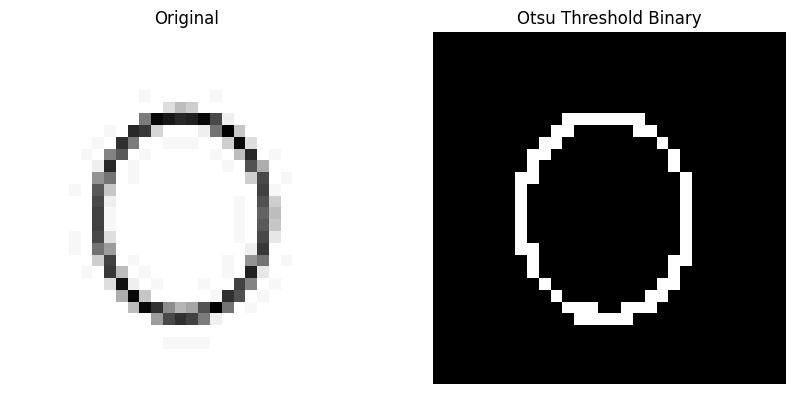

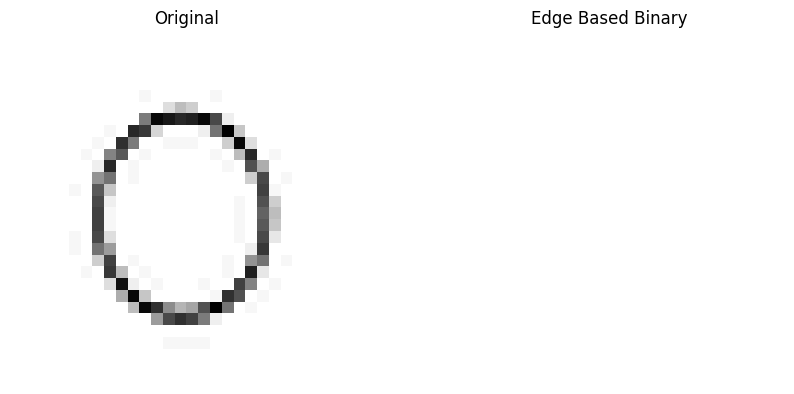

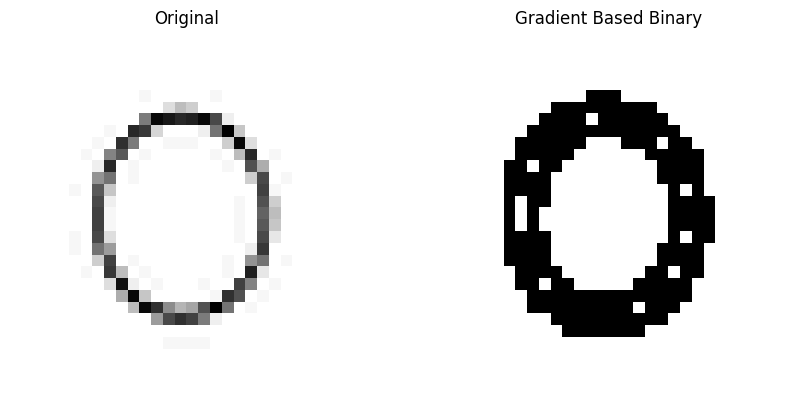

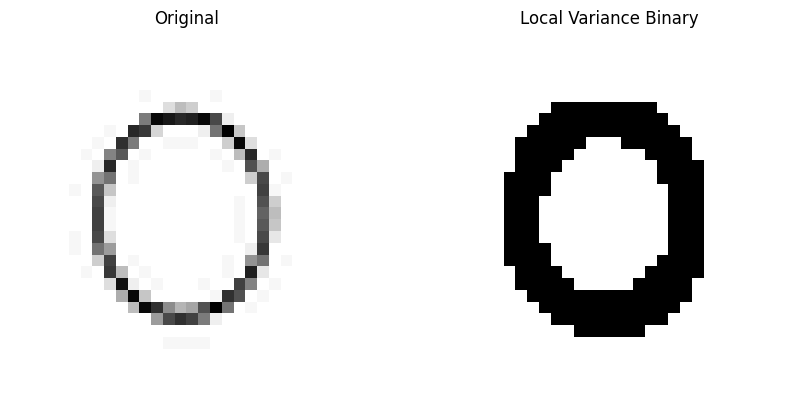

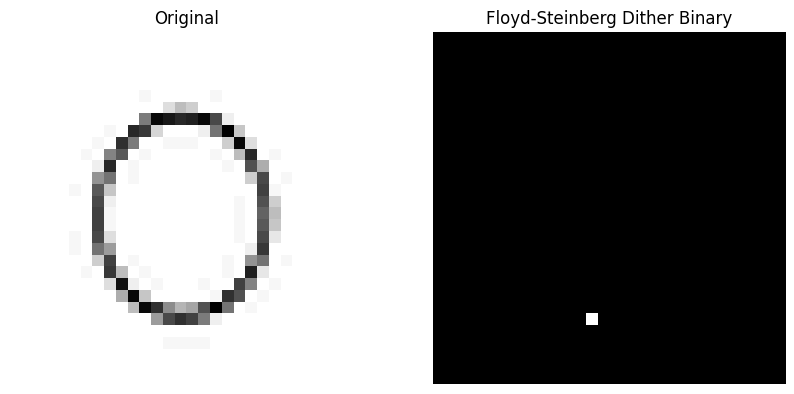

In [28]:
# Import required libraries
import numpy as np
from PIL import Image
import cv2
from scipy import ndimage
from skimage import feature, filters
import matplotlib.pyplot as plt
%matplotlib inline

# Utility functions for loading and displaying images
def load_and_preprocess(image_path, size=(30, 30)):
    """Load and preprocess image to grayscale."""
    img = Image.open(image_path)
    img = img.convert('L')  # Convert to grayscale
    img = img.resize(size , Image.Resampling.LANCZOS)
    return np.array(img)

def plot_binary(binary_array, title):
    """Plot binary array using matplotlib."""
    plt.figure(figsize=(5, 5))
    plt.imshow(binary_array, cmap='binary')
    plt.title(title)
    plt.axis('off')
    plt.show()

def plot_comparison(original, binary_array, method_name):
    """Plot original and binary version side by side."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.imshow(original, cmap='gray')
    ax1.set_title('Original')
    ax1.axis('off')
    ax2.imshow(binary_array, cmap='binary')
    ax2.set_title(f'{method_name} Binary')
    ax2.axis('off')
    plt.show()

# Cell for different binarization methods
def simple_threshold(img, threshold=127):
    """Simple threshold-based binarization."""
    return (img > threshold).astype(int)

def adaptive_threshold(img):
    """Adaptive thresholding using local regions."""
    img_uint8 = img.astype(np.uint8)
    binary = cv2.adaptiveThreshold(
        img_uint8, 1, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2
    )
    return binary

def otsu_threshold(img):
    """Otsu's method for optimal thresholding."""
    img_uint8 = img.astype(np.uint8)
    _, binary = cv2.threshold(img_uint8, 0, 1, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return binary

def edge_based(img):
    """Edge-based binarization using Canny edge detection."""
    edges = feature.canny(img/255.0, sigma=1)
    return ndimage.binary_dilation(edges).astype(int)

def gradient_based(img):
    """Gradient-based binarization using Sobel filters."""
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
    gradient_magnitude = np.sqrt(sobelx**2 + sobely**2)
    return (gradient_magnitude > np.mean(gradient_magnitude)).astype(int)

def local_variance(img):
    """Binarization based on local variance."""
    local_var = ndimage.generic_filter(img, np.var, size=3)
    return (local_var > np.mean(local_var)).astype(int)

def dither_floyd_steinberg(img):
    """Floyd-Steinberg dithering for better detail preservation."""
    img_copy = img.astype(float)
    height, width = img_copy.shape
    
    for y in range(height-1):
        for x in range(width-1):
            old_pixel = img_copy[y, x]
            new_pixel = round(old_pixel/255.0) * 255
            img_copy[y, x] = new_pixel
            error = old_pixel - new_pixel
            
            if x < width-1:
                img_copy[y, x+1] += error * 7/16
            if y < height-1:
                if x > 0:
                    img_copy[y+1, x-1] += error * 3/16
                img_copy[y+1, x] += error * 5/16
                if x < width-1:
                    img_copy[y+1, x+1] += error * 1/16
            
    return (img_copy > 127).astype(int)

# Cell for processing an image with all methods
def process_image(image_path):
    # Load and show original image
    img = load_and_preprocess(image_path)
    plt.figure(figsize=(5, 5))
    plt.imshow(img, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')
    plt.show()
    
    # Process with each method
    methods = {
        'Simple Threshold': simple_threshold,
        'Adaptive Threshold': adaptive_threshold,
        'Otsu Threshold': otsu_threshold,
        'Edge Based': edge_based,
        'Gradient Based': gradient_based,
        'Local Variance': local_variance,
        'Floyd-Steinberg Dither': dither_floyd_steinberg
    }
    
    # Create and display all versions
    results = {}
    for name, method in methods.items():
        binary = method(img)
        results[name] = binary
        plot_comparison(img, binary, name)
        
    return results

# Example usage cell
# Replace with your image path
image_path = "/Users/siddmittal/Documents/School/syde-capstone/research/image2.jpeg"
binary_versions = process_image(image_path)

# Optional: Save specific version
def save_binary(binary_array, filename):
    """Save binary array as image."""
    Image.fromarray(binary_array * 255).convert('1').save(filename)